# CICIDS2017

## EDA and Preprocessing

In [1]:
# Basic imports
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, BatchNormalization, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

2024-06-26 20:49:56.958623: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 20:49:56.962287: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-26 20:49:57.001021: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 20:49:57.622447: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
nRowsRead = None 

df1=pd.read_csv(r"../dataset/Tuesday-WorkingHours.pcap_ISCX.csv")
df2=pd.read_csv(r"../dataset/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv")
df3=pd.read_csv(r"../dataset/Monday-WorkingHours.pcap_ISCX.csv")
df4=pd.read_csv(r"../dataset/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv")
df5=pd.read_csv(r"../dataset/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv")
df6=pd.read_csv(r"../dataset/Wednesday-workingHours.pcap_ISCX.csv")
df7=pd.read_csv(r"../dataset/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
df8=pd.read_csv(r"../dataset/Friday-WorkingHours-Morning.pcap_ISCX.csv")

In [3]:
df = pd.concat([df1,df2])
del df1,df2
df = pd.concat([df,df3])
del df3
df = pd.concat([df,df4])
del df4
df = pd.concat([df,df5])
del df5
df = pd.concat([df,df6])
del df6
df = pd.concat([df,df7])
del df7
df = pd.concat([df,df8])
del df8

nRow, nCol = df.shape

In [4]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,88,640,7,4,440,358,220,0,62.857143,107.349008,179,0,89.5,103.345698,1246875.000,17187.500000,64.000000,135.557286,445,1,640,106.666667,194.325157,497,1,538,179.333333,303.686242,530,4,0,0,0,0,164,104,10937.500000,6250.000000,0,220,66.500000,99.001837,9801.363636,0,0,0,1,0,0,0,0,0,72.545455,62.857143,89.5,164,0,0,0,0,0,0,7,440,4,358,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,88,900,9,4,600,2944,300,0,66.666667,132.287566,1472,0,736.0,849.859596,3937777.778,14444.444440,75.000000,192.795228,684,1,900,112.500000,252.411229,734,1,766,255.333333,435.323252,758,3,0,0,0,0,204,104,10000.000000,4444.444444,0,1472,253.142857,527.434262,278186.901100,0,0,0,1,0,0,0,0,0,272.615385,66.666667,736.0,204,0,0,0,0,0,0,9,600,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1205,7,4,2776,2830,1388,0,396.571429,677.274651,1415,0,707.5,816.950631,4652282.158,9128.630705,120.500000,236.433336,777,1,1205,200.833333,397.058392,1008,1,927,309.000000,491.647231,876,1,0,0,0,0,164,104,5809.128631,3319.502075,0,1415,467.166667,690.098917,476236.515200,0,0,0,1,0,0,0,0,0,509.636364,396.571429,707.5,164,0,0,0,0,0,0,7,2776,4,2830,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,88,511,7,4,452,370,226,0,64.571429,110.276708,185,0,92.5,106.809800,1608610.568,21526.418790,51.100000,90.767652,299,1,511,85.166667,131.900594,349,1,462,154.000000,224.719826,412,1,0,0,0,0,164,104,13698.630140,7827.788650,0,226,68.500000,101.933579,10390.454550,0,0,0,1,0,0,0,0,0,74.727273,64.571429,92.5,164,0,0,0,0,0,0,7,452,4,370,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,773,9,4,612,2944,306,0,68.000000,134.933317,1472,0,736.0,849.859596,4600258.732,16817.593790,64.416667,148.698266,531,1,773,96.625000,196.665733,580,1,675,225.000000,348.901132,627,1,0,0,0,0,204,104,11642.949550,5174.644243,0,1472,254.000000,527.520762,278278.153800,0,0,0,1,0,0,0,0,0,273.538461,68.000000,736.0,204,0,0,0,0,0,0,9,612,4,2944,8192,2053,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
from itertools import combinations
def data_cleaning(df):
    df.columns=df.columns.str.strip()
    print("Dataset Shape: ",df.shape)
    
    num=df._get_numeric_data()
    num[num<0]=0
    
    zero_variance_cols=[]
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(columns=zero_variance_cols, axis=1, inplace=True)
    print("Zero Variance Columns: ", zero_variance_cols, "are dropped.")
    print("Shape after removing the zero varaince columns: ",df.shape)
    
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    print(df.isna().any(axis=1).sum(),"rows dropped")
    df.dropna(inplace=True)
    print("Shape after Removing NaN: ",df.shape)
    
    df.drop_duplicates(inplace=True)
    print("Shape after dropping duplicates: ",df.shape)
    
    column_pairs = [(i,j) for i,j in combinations(df,2) if df[i].equals(df[j])]
    ide_cols=[]
    for col_pair in column_pairs:
        ide_cols.append(col_pair[1])
    df.drop(columns=ide_cols,axis=1,inplace=True)
    print("Columns which have identical values: ",column_pairs," dropped!")
    print("Shape after removing identical value columns: ",df.shape)
    return df
df=data_cleaning(df)

Dataset Shape:  (2830743, 79)


Zero Variance Columns:  ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] are dropped.
Shape after removing the zero varaince columns:  (2830743, 71)
2867 rows dropped
Shape after Removing NaN:  (2827876, 71)
Shape after dropping duplicates:  (2520798, 71)
Columns which have identical values:  [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')]  dropped!
Shape after removing identical value columns:  (2520798, 66)


In [6]:
df['Label'].value_counts()

Label
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

In [7]:
print(df.columns)

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd URG Flags',
       'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s',
       'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length',
       'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance',
       'FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',

In [8]:
df_encoded = df.copy()

le = LabelEncoder()

df_encoded['Label'] = le.fit_transform(df['Label'])

X = df_encoded.drop('Label', axis=1)
y = df_encoded['Label']

In [9]:
X = df.drop('Label', axis=1)
y = df['Label']

X_train_1, X_test, y_train_1, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train_1, y_train_1, test_size=0.17, random_state=42, stratify=y_train_1)

In [17]:
print(y_train.value_counts())





Label
BENIGN                        1478062
DoS Hulk                       121943
DDoS                            90314
PortScan                        63985
DoS GoldenEye                    7257
FTP-Patator                      4184
DoS slowloris                    3799
DoS Slowhttptest                 3688
SSH-Patator                      2271
Bot                              1374
Web Attack � Brute Force         1037
Web Attack � XSS                  460
Infiltration                       26
Web Attack � Sql Injection         15
Heartbleed                          7
Name: count, dtype: int64


In [18]:
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Define the sampling strategies
sampling_strategy_over = {
    "DoS Hulk": 200000, 
    "DDoS": 150000, 
    "PortScan": 100000, 
    "DoS GoldenEye": 10000, 
    "FTP-Patator": 10000, 
    "DoS slowloris": 10000, 
    "DoS Slowhttptest": 10000, 
    "SSH-Patator": 10000, 
    "Bot": 10000, 
    "Web Attack � Brute Force": 10000, 
    "Web Attack � XSS": 10000, 
    "Infiltration": 10000, 
    "Web Attack � Sql Injection": 10000, 
    "Heartbleed": 10000
}

sampling_strategy_under = {
    "BENIGN": 500000
}


# Apply SMOTE 
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)

In [19]:
over = SMOTE(sampling_strategy=sampling_strategy_over)
under = RandomUnderSampler(sampling_strategy=sampling_strategy_under)


X_train_res, y_train_res = over.fit_resample(X_train, y_train)
X_train_res, y_train_res= under.fit_resample(X_train_res, y_train_res)

print(y_train_res.value_counts())


Label
BENIGN                        500000
DoS Hulk                      200000
DDoS                          150000
PortScan                      100000
Bot                            10000
DoS GoldenEye                  10000
DoS Slowhttptest               10000
DoS slowloris                  10000
FTP-Patator                    10000
Heartbleed                     10000
Infiltration                   10000
SSH-Patator                    10000
Web Attack � Brute Force       10000
Web Attack � Sql Injection     10000
Web Attack � XSS               10000
Name: count, dtype: int64


In [28]:
import sklearn
print(sklearn.__version__)

1.0.2


In [20]:
# Normalize the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Reshape the data for Conv1D
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], X_val_scaled.shape[1], 1))

# One-hot encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_res)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)
y_train_one_hot = to_categorical(y_train_encoded)
y_test_one_hot = to_categorical(y_test_encoded)
y_val_one_hot = to_categorical(y_val_encoded)

# Calculate class weights (for scikit-learn version >= 0.22.0)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weight_dict = dict(zip(np.unique(y_train_res), class_weights))

In [21]:
np.unique(y_train_encoded)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [22]:
# Initialize the model
model_fine_tuned = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(50, activation='relu'),
    Dropout(0.2),
    Dense(y_train_one_hot.shape[1], activation='softmax')
])

# Compile the model
model_fine_tuned.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

/x1/rsingh8/anaconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-26 20:59:25.170744: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [23]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Minority class indexes
minority_class_indexes = set(range(8, 15))  # Classes from 8 to 14


In [32]:
class_weights

array([0.14133333, 7.06666667, 0.47111111, 7.06666667, 0.35333333,
       7.06666667, 7.06666667, 7.06666667, 7.06666667, 7.06666667,
       0.70666667, 7.06666667, 7.06666667, 7.06666667, 7.06666667])

In [24]:
# Training the model with custom loop
epochs = 10
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    if epoch > 0:  
        adjusted_weights = {class_id: (weight * 2 if class_id in minority_class_indexes else weight)
                            for class_id, weight in class_weight_dict.items()}
    else:
        adjusted_weights = class_weight_dict  

    model_fine_tuned.fit(
        X_train_scaled, y_train_one_hot, batch_size=32,
        validation_data=(X_val_scaled, y_val_one_hot),
        class_weight=adjusted_weights,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

Epoch 1/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 159s 5ms/step - accuracy: 0.9410 - loss: 0.1719 - val_accuracy: 0.9768 - val_loss: 0.0513 - learning_rate: 0.0010
Epoch 2/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 158s 5ms/step - accuracy: 0.9686 - loss: 0.0778 - val_accuracy: 0.9779 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 3/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 153s 5ms/step - accuracy: 0.9720 - loss: 0.0693 - val_accuracy: 0.9746 - val_loss: 0.0580 - learning_rate: 0.0010
Epoch 4/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 150s 5ms/step - accuracy: 0.9741 - loss: 0.0637 - val_accuracy: 0.9796 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 5/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 157s 5ms/step - accuracy: 0.9767 - loss: 0.0576 - val_accuracy: 0.9892 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 6/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 148s 4ms/step - accuracy: 0.9770 - loss: 0.0564 - val_accuracy: 0.9776 - val_loss: 0.0433 - learning_rate: 0.0010
Epoch 7/10
33125/33125 ━━━━━━━━━━━━━━━━━━━━ 154s 5ms

In [25]:
test_loss, test_accuracy = model_fine_tuned.evaluate(X_test_scaled, y_test_one_hot, verbose=0)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 98.14%


In [26]:
print("Test Loss: {:.2f}%".format(test_loss * 100))

Test Loss: 3.60%


In [25]:
# Predict the classes with the model
y_pred = model_fine_tuned.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test_one_hot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


15755/15755 ━━━━━━━━━━━━━━━━━━━━ 19s 1ms/step
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      0.99    419012
                       Bot       0.33      0.75      0.45       390
                      DDoS       1.00      1.00      1.00     25603
             DoS GoldenEye       0.99      0.96      0.97      2057
                  DoS Hulk       0.96      1.00      0.98     34569
          DoS Slowhttptest       0.98      0.98      0.98      1046
             DoS slowloris       0.97      0.99      0.98      1077
               FTP-Patator       0.99      1.00      1.00      1186
                Heartbleed       1.00      0.50      0.67         2
              Infiltration       0.58      1.00      0.74         7
                  PortScan       0.97      1.00      0.99     18139
               SSH-Patator       0.92      0.93      0.92       644
  Web Attack � Brute Force       0.47      0.13      0.20       294
W

In [27]:
# Predict the classes with the model
y_pred = model_fine_tuned.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded y_test to class labels
y_true = np.argmax(y_test_one_hot, axis=1)

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))


11817/11817 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
                            precision    recall  f1-score   support

                    BENIGN       1.00      0.98      0.99    314259
                       Bot       0.32      0.92      0.48       292
                      DDoS       1.00      1.00      1.00     19202
             DoS GoldenEye       0.98      0.98      0.98      1543
                  DoS Hulk       1.00      0.96      0.98     25927
          DoS Slowhttptest       0.88      0.99      0.93       784
             DoS slowloris       0.98      0.99      0.98       808
               FTP-Patator       1.00      0.99      0.99       890
                Heartbleed       1.00      0.50      0.67         2
              Infiltration       0.17      1.00      0.29         5
                  PortScan       0.74      1.00      0.85     13604
               SSH-Patator       0.93      0.94      0.93       483
  Web Attack � Brute Force       0.56      0.15      0.23       220
W

In [28]:
report = classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_, output_dict=True)


In [29]:
print(f"Overall Precision: {report['weighted avg']['precision']:.2f}")
print(f"Overall Recall: {report['weighted avg']['recall']:.2f}")
print(f"Overall F1-Score: {report['weighted avg']['f1-score']:.2f}")
print(f"Accuracy: {report['accuracy']:.2f}")

Overall Precision: 0.99
Overall Recall: 0.98
Overall F1-Score: 0.98
Accuracy: 0.98


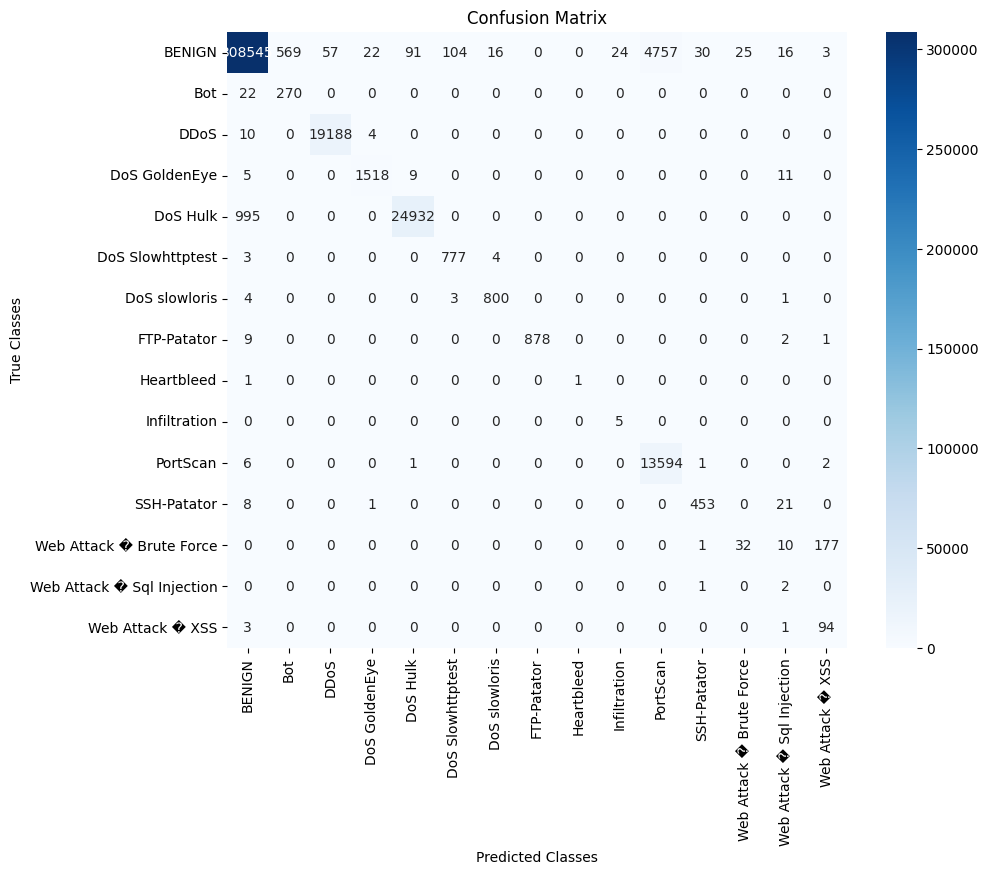

In [30]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Classes')
plt.xlabel('Predicted Classes')
plt.show()


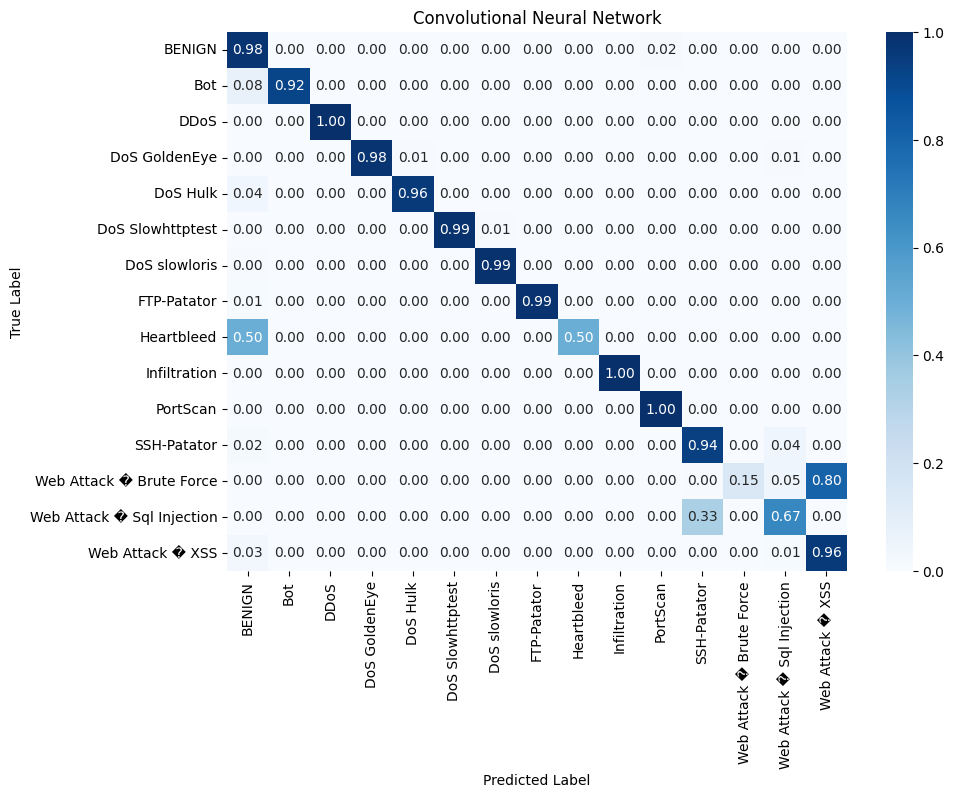

In [31]:
# Normalize the confusion matrix by rows
row_sums = conf_matrix.sum(axis=1)
conf_matrix_normalized = conf_matrix / row_sums[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Convolutional Neural Network")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()